Mount drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/
%cd DEEEP/deep-image-prior/deep-image-prior-modded/

%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/DEEEP/deep-image-prior/deep-image-prior-modded
 activation_maximization.ipynb        moddedinpaintingfortable.ipynb
 allimages.png                        moddedinpaintingfortable.py
'Copy of Copy of Experiment1.ipynb'   models/
 data/                                Prepimagesforfig.ipynb
 denoising.ipynb                     'psnrresults (1).gsheet'
 Dockerfile                           psnrresults.csv
 environmen

Import Libraries

In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import prettytable
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *
from utils.common_utils_modded import *
from skimage.measure import compare_psnr

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

Initialize Variables

In [0]:
PLOT = True
imsize = -1
dim_div_by = 64
shape = [512,512]

Parse, Plot Dataset and Get Masks

['cameramangray.png', 'mangray.png']


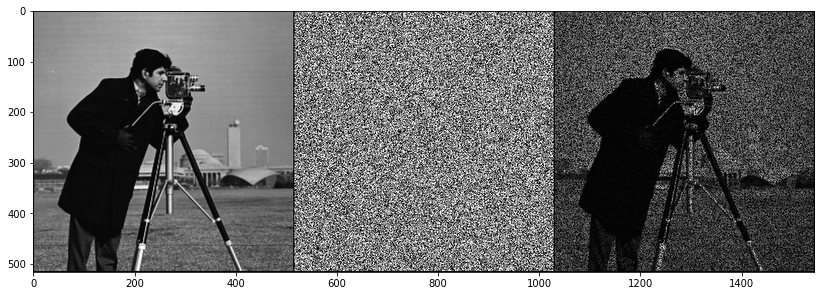

cameramangray.png


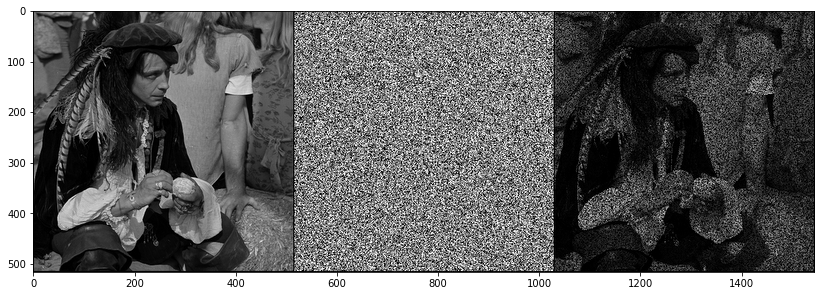

mangray.png


In [0]:
print(os.listdir('data/tabledata4/'))
imagenames = os.listdir('data/tabledata4/')
imagedict = dict();
psnrdict = dict();
maskdict = dict();
for file in os.listdir('data/tabledata4/'):
  impath = 'data/tabledata4/' + file
  img_pil, img_np = get_image(impath, shape)
  img_var = np_to_torch(img_np).type(dtype)
  imagedict[file] = img_var
  mask_pil = get_bernoulli_mask(img_pil,0.5)
  mask_np = pil_to_np(mask_pil)
  mask_var = np_to_torch(mask_np).type(dtype)
  maskdict[file] = mask_var
  psnrdict[file] = [0]
  plot_image_grid([img_np, mask_np, mask_np*img_np], 3,11);
  print(file)

Net Params

In [0]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
i = 0
# Same params and net as in super-resolution and denoising
INPUT = 'noise'
input_depth = 32
LR = 0.1 
num_iter = 12001
param_noise = False
show_every = 100
figsize = 5
reg_noise_std = 0.03

# Loss
mse = torch.nn.MSELoss().type(dtype)

Sample Net for Parameter Calculation

In [0]:
net = skip(input_depth, img_np.shape[0], 
            num_channels_down = [128] * 5,
            num_channels_up =   [128] * 5,
            num_channels_skip =    [128] * 5,  
            filter_size_up = 3, filter_size_down = 3, 
            upsample_mode='nearest', filter_skip_size=1,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

net = net.type(dtype)

# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

Number of params: 3002369


Closure Definition

In [0]:
def closure(imagename):
    
    global i
  
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
    mask_var = maskdict[imagename]
        
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)

        psnrval = compare_psnr(torch_to_np(img_var),out_np)
        psnrdict.setdefault(imagename).append(psnrval)

    i += 1

    return total_loss

Iterate

In [0]:


for key in imagedict:

  print(key)

  net_input = get_noise(input_depth, INPUT, torch_to_np(imagedict[key]).shape[1:]).type(dtype)
  
  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()

  net = skip(input_depth, torch_to_np(imagedict[key]).shape[0], 
            num_channels_down = [128] * 5,
            num_channels_up =   [128] * 5,
            num_channels_skip =    [128] * 5,  
            filter_size_up = 3, filter_size_down = 3, 
            upsample_mode='nearest', filter_skip_size=1,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
  net = net.type(dtype)

  img_var = imagedict[key]
  p = get_params(OPT_OVER, net, net_input)
  optimizem(OPTIMIZER, p, closure, LR, num_iter,key)
  i = 0



cameramangray.png
Starting optimization with ADAM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


mangray.png
Starting optimization with ADAM


In [0]:
print(psnr)

NameError: ignored

In [0]:
for key in psnrdict:

  print(key)
  print(len(psnrdict[key]))

cameramangray.png
202
mangray.png
202


In [0]:
for key in psnrdict:

  print(key)
  print(len(psnrdict[key]))

cameramangray.png
323
mangray.png
323


Print Results

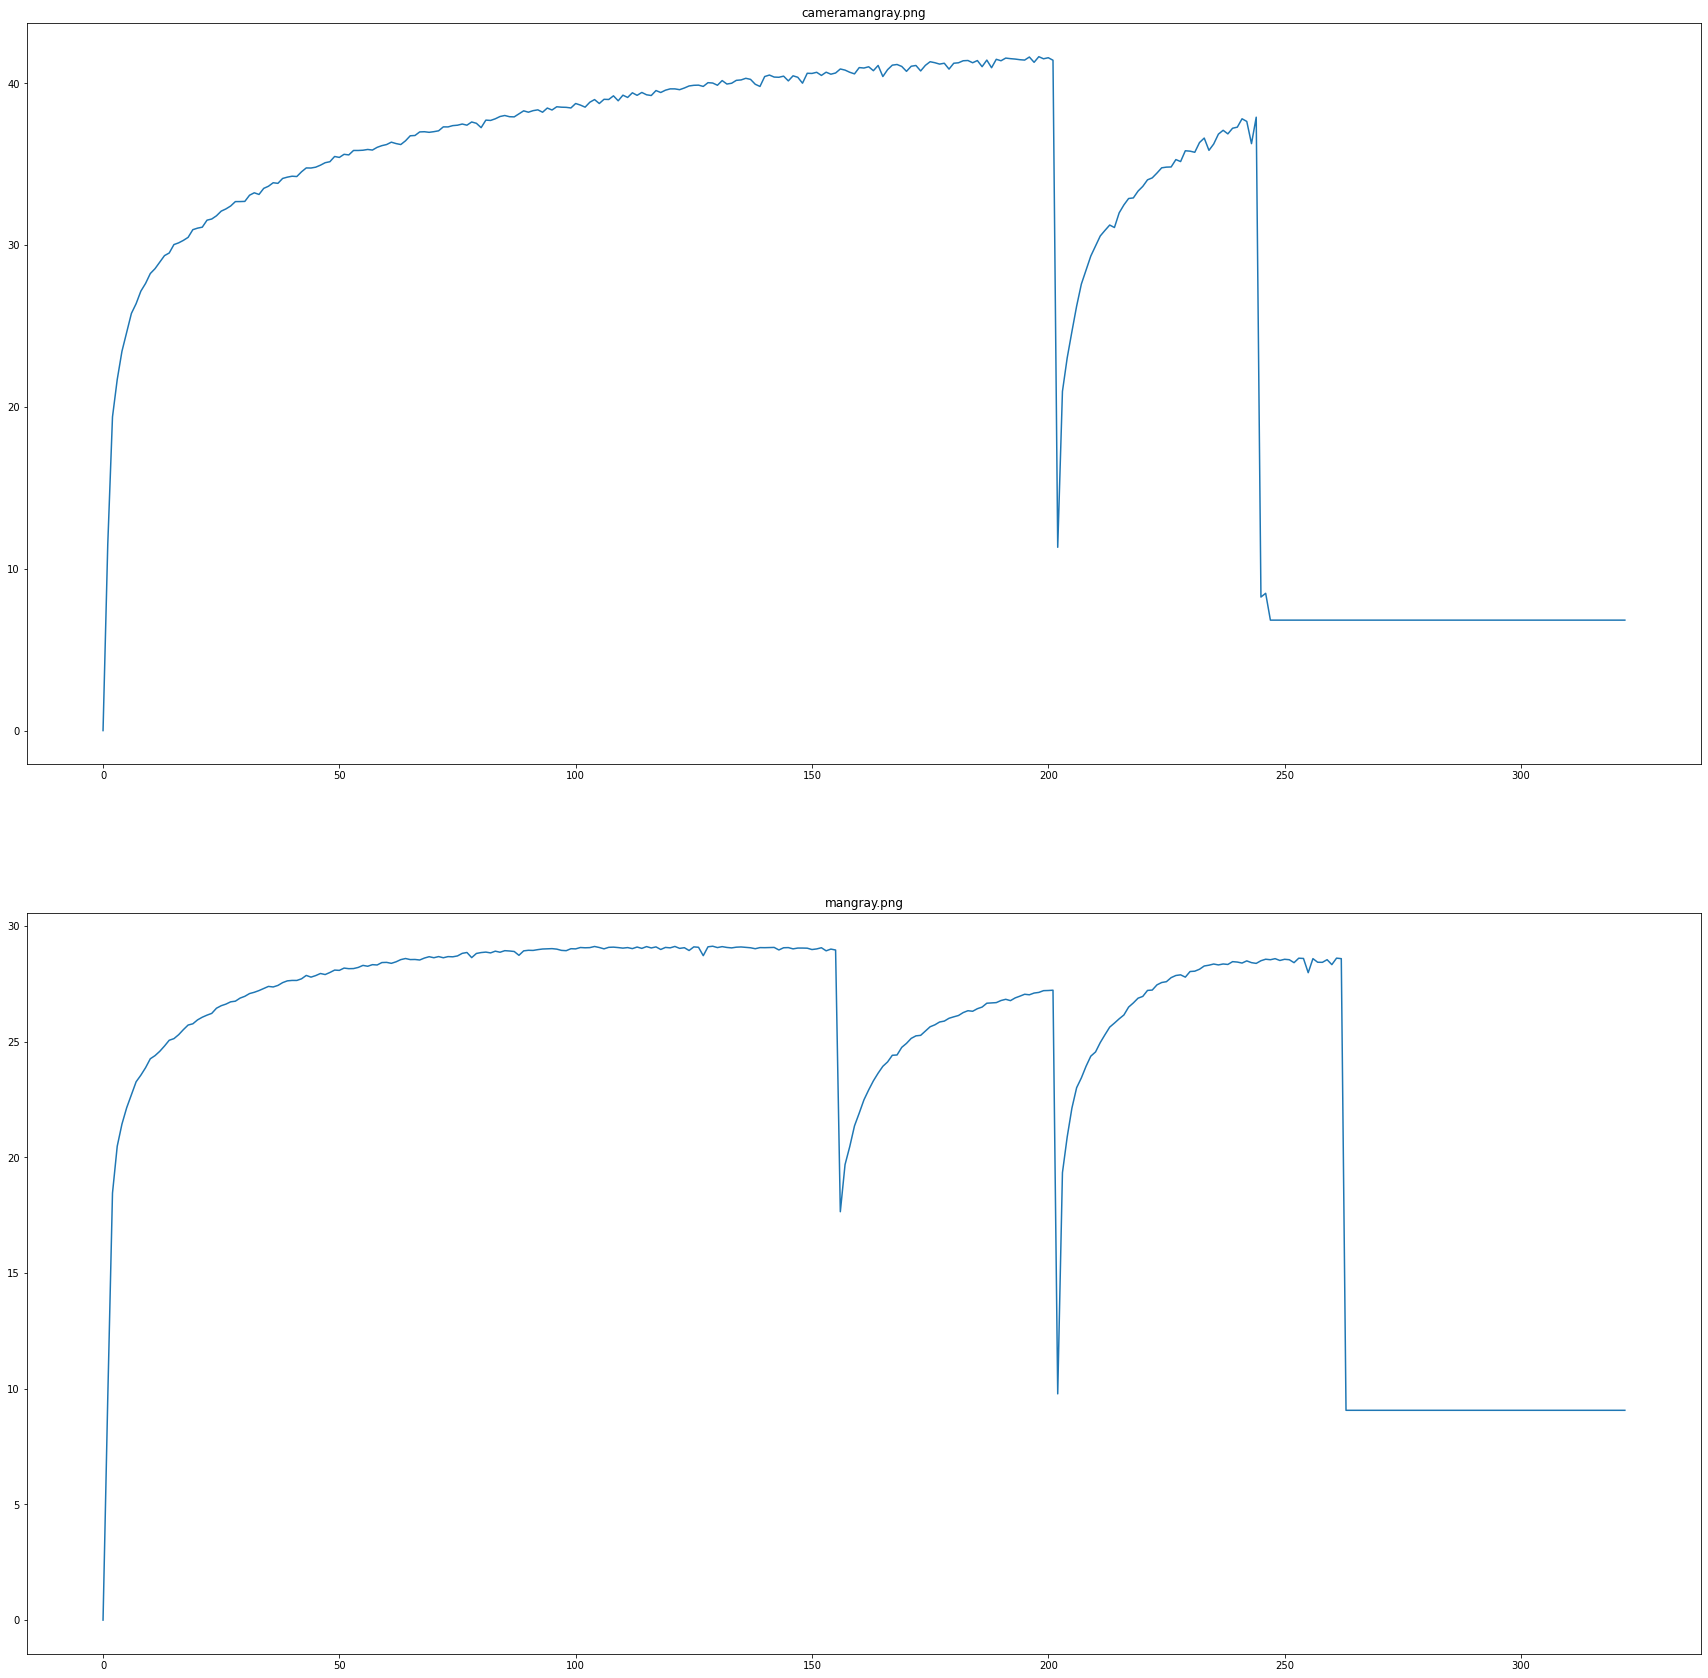

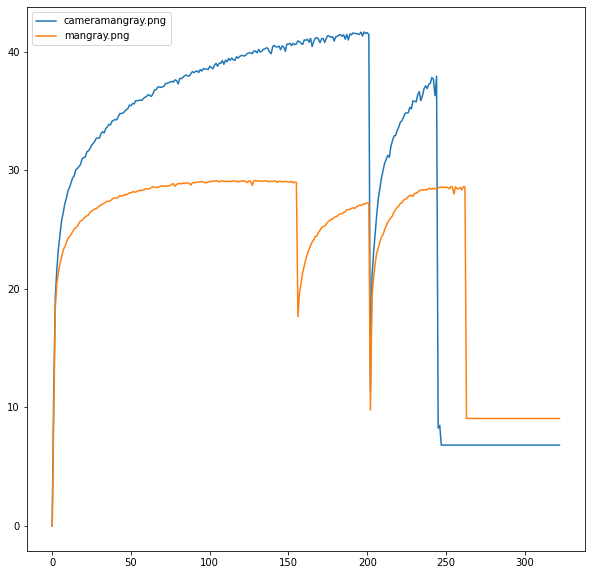

+-------------------+--------------------+
| cameramangray.png |    mangray.png     |
+-------------------+--------------------+
| 41.65327009742577 | 29.128080164839613 |
+-------------------+--------------------+


In [0]:
numimages = len(psnrdict)
fig1, axs = plt.subplots(numimages,figsize=(30,30))
fig2, axall = plt.subplots(figsize=(10,10))
n = 0
maxpsnrs = dict()

table = prettytable.PrettyTable()

for key in psnrdict:
 
  axs[n].set_title(key)
  axs[n].plot(psnrdict[key])
  n+=1
  axall.plot(psnrdict[key],label=key)

  maxpsnrs[key] = np.max(psnrdict[key])

  table.add_column(key,[maxpsnrs[key]])

plt.legend(loc='upper left')
plt.show(fig1)
plt.show(fig2)

print(table)

In [0]:
out2 = net(net_input)
out2np = torch_to_np(out2)
plt.imshow(out2np[0],cmap='gray')
plt.imshow(torch_to_np(net_input))

RuntimeError: ignored

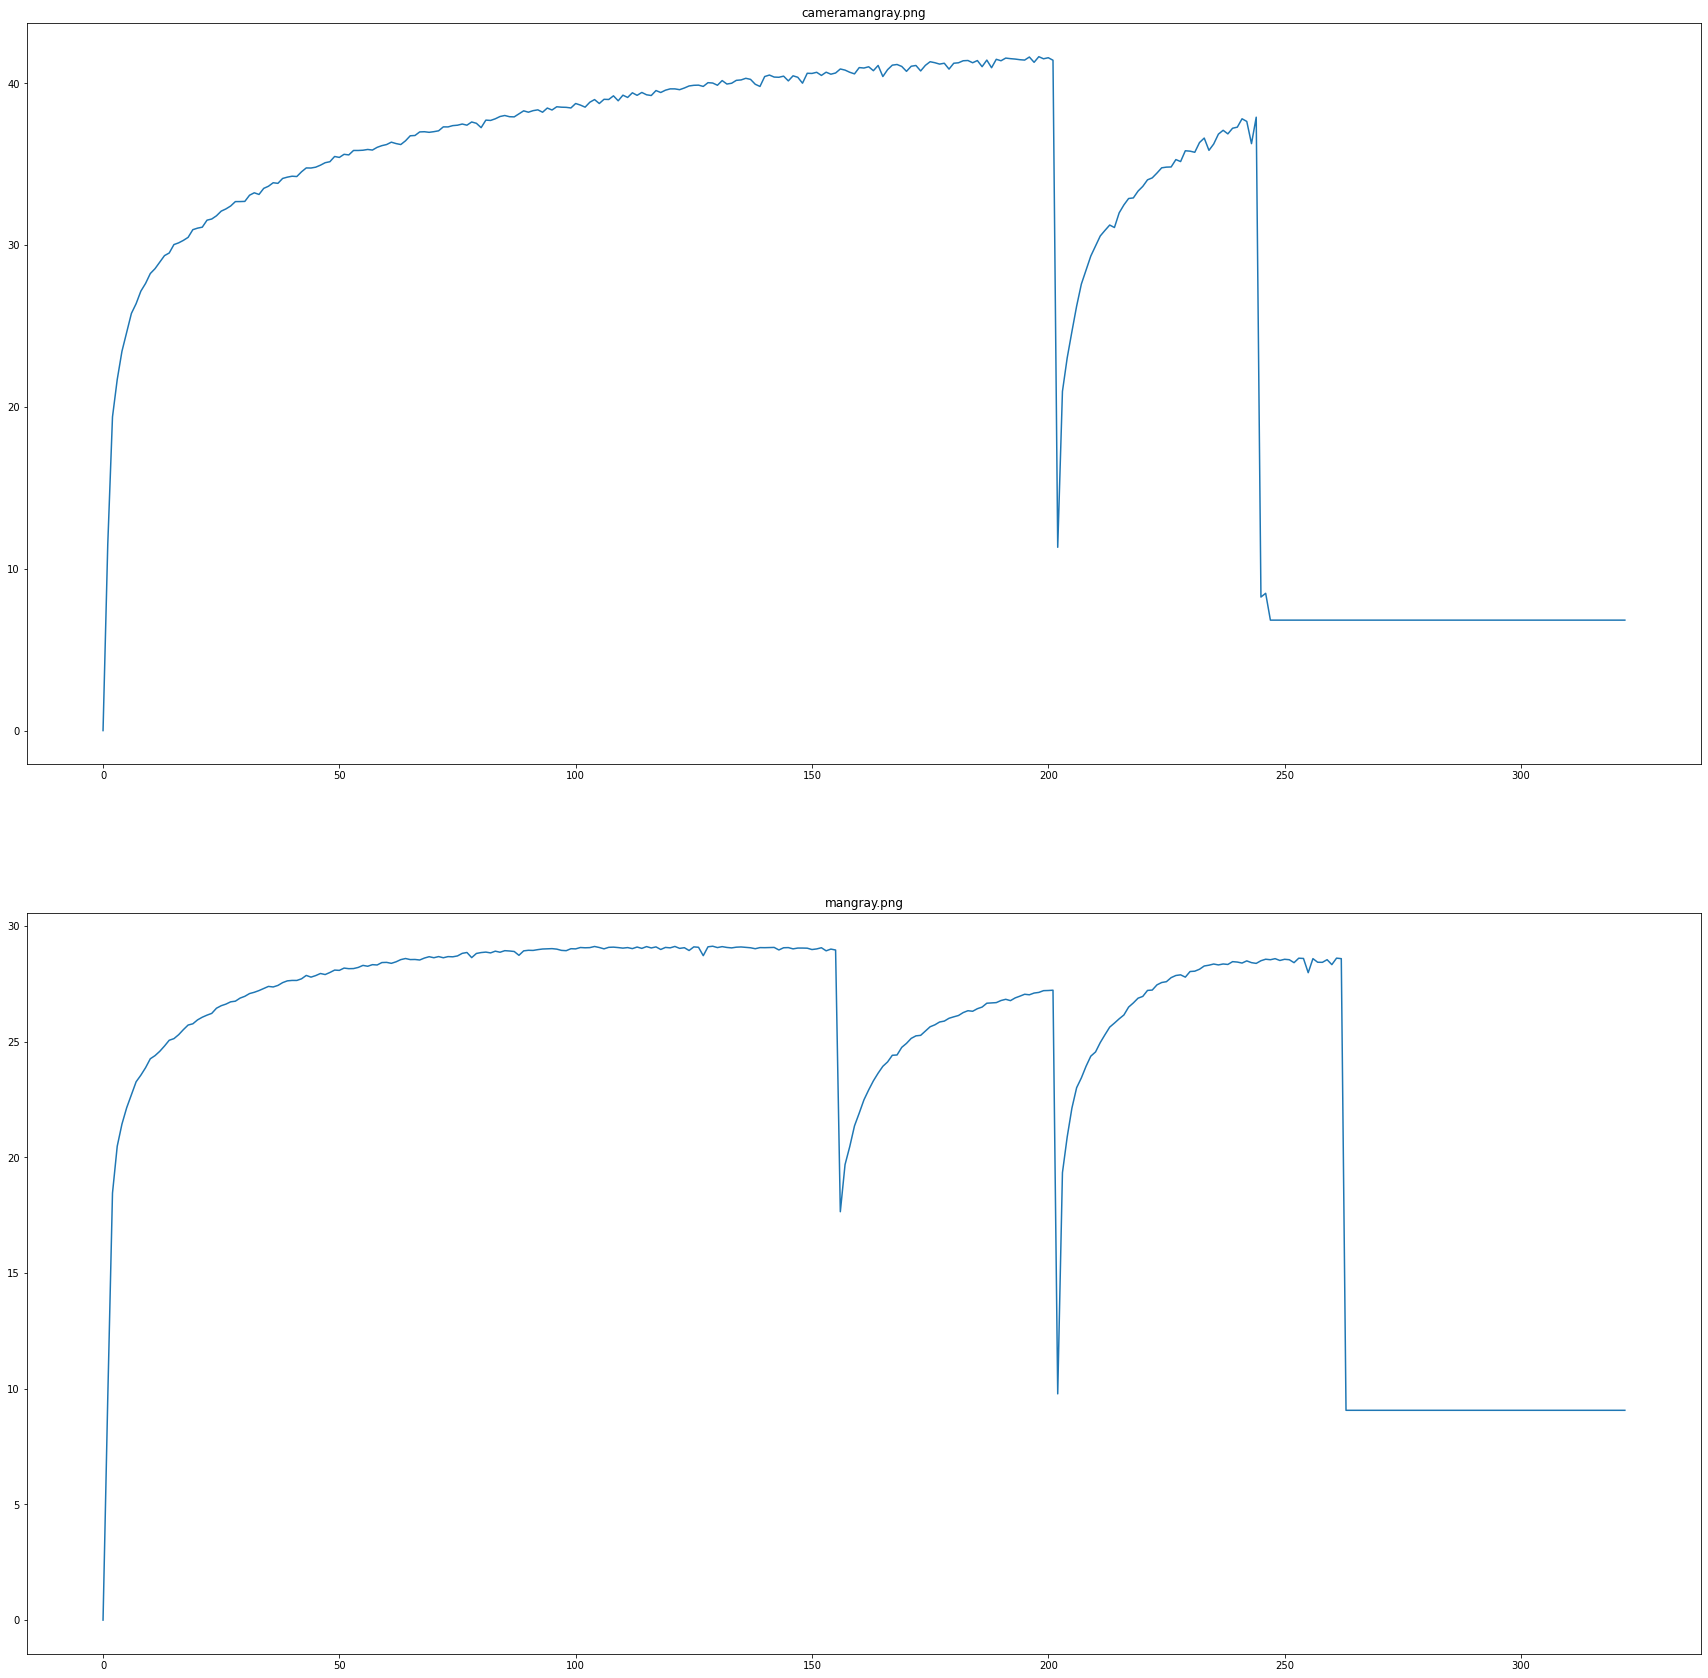

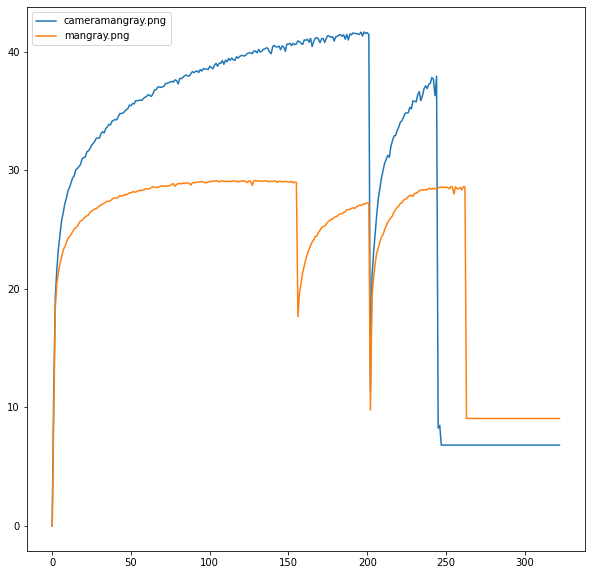

+-------------------+--------------------+
| cameramangray.png |    mangray.png     |
+-------------------+--------------------+
| 41.65327009742577 | 29.128080164839613 |
+-------------------+--------------------+


In [0]:
numimages = len(psnrdict)
fig1, axs = plt.subplots(numimages,figsize=(30,30))
fig2, axall = plt.subplots(figsize=(10,10))
n = 0
maxpsnrs = dict()

table = prettytable.PrettyTable()

for key in psnrdict:
 
  axs[n].set_title(key)
  axs[n].plot(psnrdict[key])
  n+=1
  axall.plot(psnrdict[key],label=key)

  maxpsnrs[key] = np.max(psnrdict[key])

  table.add_column(key,[maxpsnrs[key]])

plt.legend(loc='upper left')
plt.show(fig1)
plt.show(fig2)

print(table)





Save Results

In [0]:
import csv



In [2]:
with open('psnrresults13.csv','w') as f:
    w = csv.writer(f)
    w.writerow(psnrdict.keys())
    w.writerow(psnrdict.values())

NameError: ignored

In [0]:
!ls

activation_maximization.ipynb	moddedinpaintingfortable.py
data				models
denoising.ipynb			Prepimagesforfig.ipynb
Dockerfile			psnrresults.csv
environment.yml			README.md
Experiment1.ipynb		restoration.ipynb
feature_inversion.ipynb		sr_prior_effect.ipynb
flash-no-flash.ipynb		super-resolution_eval_script.py
inpainting.ipynb		super-resolution.ipynb
LICENSE				trialpsnrs.csv
moddedinpaintingfortable.ipynb	utils


In [0]:
with open('maxpsnrs.csv','w') as f:
    w = csv.writer(f)
    w.writerow(maxpsnrs.keys())
    w.writerow(maxpsnrs.values())

In [0]:
out1 = net(net_input)

In [0]:
out1_np = torch_to_np(out1)

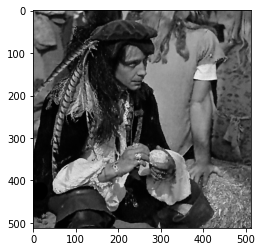

In [0]:
plt.imshow(out1_np[0],cmap='gray')